In [1]:
# !unzip -qq "/content/drive/MyDrive/코로나19.zip"

In [2]:
!apt-get install -y fonts-nanum

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.


In [3]:
!ls

'서울시 코로나19 확진자 현황.csv'
 drive
 sample_data
'서울시 행정구역 시군구 정보 (좌표계_ WGS1984).csv'


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sb
import folium
import matplotlib.font_manager as fm

font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font_name = fm.FontProperties(fname=font_path, size=10).get_name()
plt.rc('font', family=font_name)
font_prop = fm.FontProperties(fname=font_path, size=10)

plt.rc('font', family=font_prop.get_name())


csv 파일 읽어오기 + 필요한 자료 추출

In [14]:
df_seoul = pd.read_csv('/content/서울시 코로나19 확진자 현황.csv')
df_location = pd.read_csv('/content/서울시 행정구역 시군구 정보 (좌표계_ WGS1984).csv')
df_seoul

,연번,확진일,환자번호,국적,환자정보,지역,여행력,접촉력,조치사항,상태,이동경로,등록일,수정일,노출여부
0,5748,10.21.,25530,NaN,NaN,양천구,NaN,감염경로 조사중,NaN,NaN,NaN,2020-10-22 10:58,2020-10-22 10:58,Y
1,5747,10.21.,25528,NaN,NaN,강동구,NaN,강남서초 지인모임,NaN,NaN,NaN,2020-10-22 10:58,2020-10-22 10:58,Y
2,5746,10.21.,25525,NaN,NaN,강남구,NaN,기타 확진자 접촉,NaN,NaN,NaN,2020-10-22 10:58,2020-10-22 10:58,Y
3,5745,10.21.,25517,NaN,NaN,관악구,NaN,감염경로 조사중,NaN,NaN,NaN,2020-10-22 10:58,2020-10-22 10:58,Y
4,5744,10.21.,25504,NaN,NaN,관악구,NaN,기타 확진자 접촉,NaN,NaN,NaN,2020-10-22 10:58,2020-10-22 10:58,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5743,5,1.31.,9,NaN,NaN,성북구,NaN,#5 접촉,NaN,퇴원,이동경로 공개기간 경과,2020-10-22 10:58,2020-10-23 9:00,Y
5744,4,1.30.,7,NaN,NaN,마포구,중국 우한시,해외 접촉,NaN,퇴원,이동경로 공개기간 경과,2020-10-22 10:58,2020-10-23 9:00,Y
5745,3,1.30.,6,NaN,NaN,종로구,NaN,#3 접촉,NaN,퇴원,이동경로 공개기간 경과,2020-10-22 10:58,2020-10-23 9:00,Y
5746,2,1.30.,5,NaN,NaN,중랑구,중국 우한시,해외 접촉,NaN,퇴원,이동경로 공개기간 경과,2020-10-22 10:58,2020-10-23 9:00,Y


확진 지역 및 확진자수, 확진 경로 파악


In [6]:
print(df_seoul['지역'].value_counts().head(15))
print("-"*35)
print(df_seoul['접촉력'].value_counts().head(15))

관악구     452
송파구     361
성북구     344
타시도     331
노원구     323
강남구     296
강서구     295
은평구     259
동작구     254
도봉구     223
서초구     210
중랑구     201
영등포구    200
강동구     199
구로구     193
Name: 지역, dtype: int64
-----------------------------------
기타 확진자 접촉        818
성북구 사랑제일교회 관련    641
확인 중             586
해외 접촉 추정         415
감염경로 조사중         373
타시도 확진자 접촉       244
이태원 클럽 관련        139
8.15서울도심집회       126
리치웨이 관련          119
도봉구 다나병원          68
구로구 콜센터 관련        60
노원구 빛가온교회 관련      46
요양시설 관련           43
양천구 운동시설 관련       43
성북구 체대입시 관련       43
Name: 접촉력, dtype: int64


In [7]:
df_seoul.loc[:, ["지역","접촉력"]]

,지역,접촉력
0,양천구,감염경로 조사중
1,강동구,강남서초 지인모임
2,강남구,기타 확진자 접촉
3,관악구,감염경로 조사중
4,관악구,기타 확진자 접촉
...,...,...
5743,성북구,#5 접촉
5744,마포구,해외 접촉
5745,종로구,#3 접촉
5746,중랑구,해외 접촉


In [8]:
df_location

,순번,시군구코드,시군구명_한글,시군구명_영문,ESRI_PK,위도,경도
0,1,11320,도봉구,Dobong-gu,0,37.665861,127.031767
1,2,11380,은평구,Eunpyeong-gu,1,37.617612,126.922700
2,3,11230,동대문구,Dongdaemun-gu,2,37.583801,127.050700
3,4,11590,동작구,Dongjak-gu,3,37.496504,126.944307
4,5,11545,금천구,Geumcheon-gu,4,37.460097,126.900155
5,6,11530,구로구,Guro-gu,5,37.495486,126.858121
6,7,11110,종로구,Jongno-gu,6,37.599100,126.986149
7,8,11305,강북구,Gangbuk-gu,7,37.646995,127.014716
8,9,11260,중랑구,Jungnang-gu,8,37.595379,127.093967
9,10,11680,강남구,Gangnam-gu,9,37.495985,127.066409


코로나 확진자 상위 15개 감염지역 표시 지도로 시각화




In [9]:
m = folium.Map(location=[37.6658609,127.0317674])
for i in range(15):
  iframe = folium.IFrame(df_location['시군구명_한글'][i])
  popup = folium.Popup(iframe, min_width=150, max_width=150)
  folium.Marker([df_location['위도'][i], df_location['경도'][i]],
                popup = popup).add_to(m) 

m

In [10]:
history_data = df_seoul["접촉력"]
history_data

0        감염경로 조사중
1       강남서초 지인모임
2       기타 확진자 접촉
3        감염경로 조사중
4       기타 확진자 접촉
          ...    
5743        #5 접촉
5744        해외 접촉
5745        #3 접촉
5746        해외 접촉
5747        해외 접촉
Name: 접촉력, Length: 5748, dtype: object

접촉력에 따른 막대그래프 작성

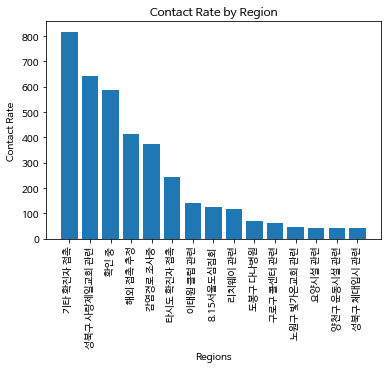

In [11]:
data = df_seoul['접촉력'].value_counts()
data.sort_values(ascending=False, inplace=True)

plt.bar(data.index[:15], data.values[:15])
plt.xlabel('Regions')
plt.ylabel('Contact Rate')
plt.title('Contact Rate by Region')
plt.xticks(rotation = 90)
plt.show()


geojson 파일을 이용해서 지도 작성하기 시도 

In [20]:
fig = px.choropleth(df_seoul,
                    locations='지역', # Column name for locations
                    locationmode='geojson-id', # Mode of location type
                    geojson='/content/drive/MyDrive/서울특별시.geojson',
                    color='지역', # Column name for color
                    hover_name='지역', # Column name for hover text
                    title='COVID-19 Confirmed Cases in Seoul',
                    color_continuous_scale='Blues',
                    color_discrete_sequence=px.colors.sequential.Blues)
fig.show()
